# Notebook 1 - Wavelets and Frequency Information

https://pywavelets.readthedocs.io/en/latest/ref/index.html

## Section 0 - Import libraries, and load metadata and beats

In [31]:
from multiprocessing import Pool, cpu_count
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import convolve
from sklearn import svm, neighbors
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pywt
import wfdb

from bc.beats import get_beats, get_beat_bank, BEAT_TYPES, SIG_NAMES
from bc.io import ann_to_df
from bc.plot import plot_beat, plot_four_beats

base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data')

# Table of record names and the beat types they contain
beat_table = pd.read_csv(os.path.join(data_dir, 'beat-types.csv'), dtype={'record':object})
beat_table.set_index('record', inplace=True)

# Sampling frequency and period
fs = 360
dt = 1 / fs

In [2]:
# Load Beats, applying the standard ecg bandpass filter
n_beats, n_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='N', filter_beats=True, fixed_width=240)
l_beats, l_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='L' ,filter_beats=True, fixed_width=240)
r_beats, r_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='R', filter_beats=True, fixed_width=240)
v_beats, v_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table,
                                   wanted_type='V', filter_beats=True, fixed_width=240)

sample_beats = [n_beats[0], l_beats[0], r_beats[0], v_beats[0]]

## Section 1 - Explore Wavelets

We are using the `pywt` library. Explore the abailable wavelet families and wavelets.

We have 3 tasks for our continuous wavelet transform:
1. Choose wavelet types that will discern the different beats
2. Choose scales to match the features

In [ ]:
# All wavelet families
print(pywt.families(), '\n')
# All wavelets
print(pywt.wavelist(), '\n')
# All wavelets of a particular family
print(pywt.wavelist(family='bior'), '\n')
# Continuous wavelets
print(pywt.wavelist(kind='continuous'), '\n')

In [ ]:
# Plot the continuous wavelet family functions, excluding complex values ones
for family in pywt.wavelist(kind='continuous'):
    if family not in ['cmor', 'shan', 'fbsp']:
        wavelet = pywt.ContinuousWavelet(family)
        if not wavelet.complex_cwt:
            plt.plot(wavelet.wavefun(level=8)[0])
            plt.title(family)
            plt.show()

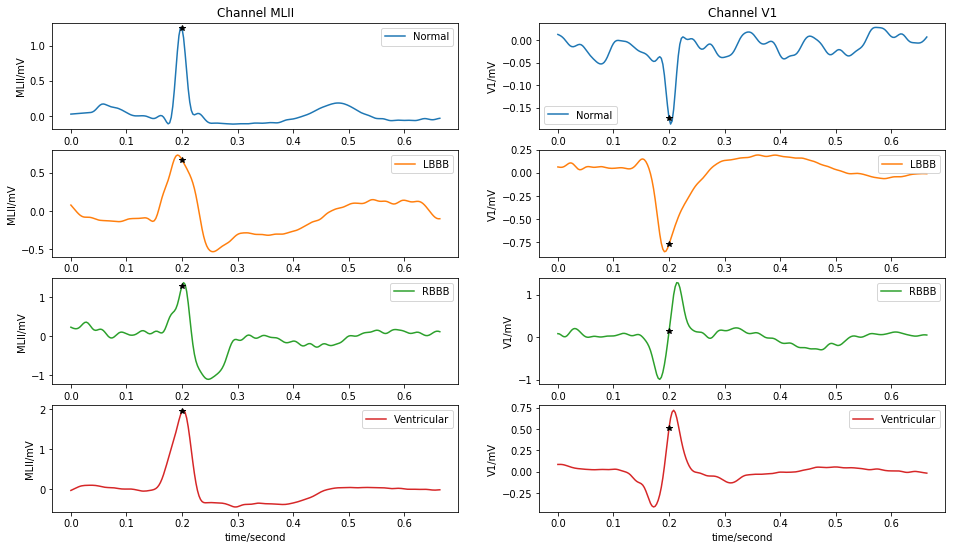

In [53]:
# Visualize one of each beat type to compare with wavelets
plot_four_beats(beats=[n_beats[0], l_beats[0], r_beats[0], v_beats[0]],
                centers=[n_centers[0], l_centers[0], r_centers[0], v_centers[0]])

### Question 1: Which wavelets should be used for the continuous wavelet transform?

We will use them to detect the ECG morphologies. It will be most effective to choose ones that are shaped similarly to the various ECG segments.

In [ ]:
# In this exercise, we will select Gaus1 and Gaus2.

### Question 2: Which scales should we use for the continuous wavelet transform?

We want wavelet scales that capture patterns of the relevant frequencies.

Exploring center frequencies of wavelets with scales: [2, 4, 8, 16, 32, 64]
gaus1 wavelet center frequencies: [ 36.     18.      9.      4.5     2.25    1.125]


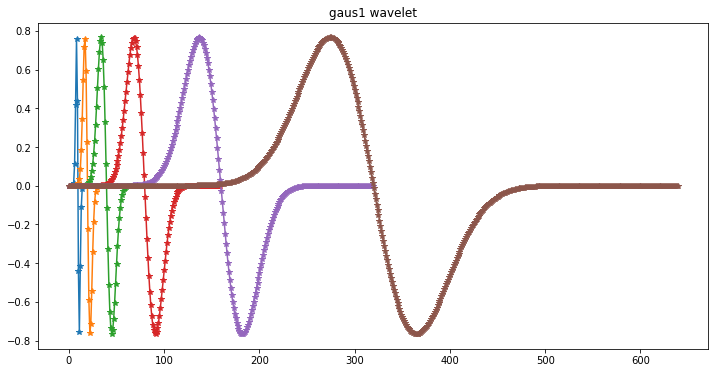

gaus2 wavelet center frequencies: [ 54.      27.      13.5      6.75     3.375    1.6875]


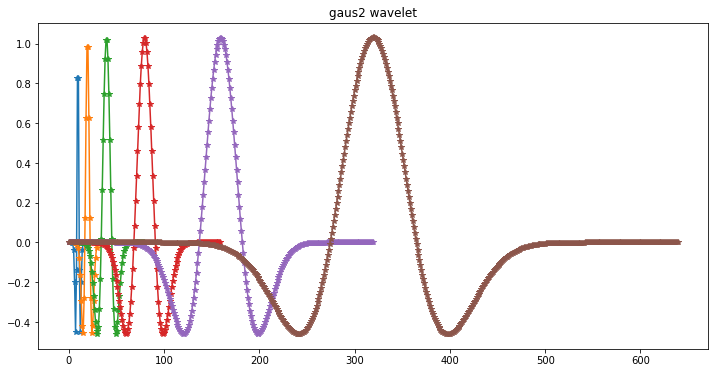

In [3]:
# Regular qrs width is about 0.05s = 0.05 * 360 = 18 samples
# A period of 0.05s corresponds to 1/.05 = 20Hz

wavelet_types = ['gaus1', 'gaus2']
scales = [2, 4, 8, 16, 32, 64]

print('Exploring center frequencies of wavelets with scales:', scales)
for w in wavelet_types:
    wavelet = pywt.ContinuousWavelet(w)
    plt.figure(figsize=(12, 6))
    plt.title('{} wavelet'.format(w))
    f_centers = pywt.scale2frequency(wavelet=w, scale=scales) / dt
    print('{} wavelet center frequencies:'.format(w), f_centers)
#     plt.legend()
    for s in scales:
        psi, _ = wavelet.wavefun(length=int((wavelet.upper_bound - wavelet.lower_bound) * s))
        plt.plot(psi, '*-')
    plt.show()
    
# help(wavelet.wavefun)
# help(pywt.scale2frequency)
# help(pywt.cwt)

In [4]:
# Scales to use for gaus1 and gaus2
ecg_wavelet_scales = [[2, 4, 8, 16, 32, 64], [4, 8, 16, 32, 64]]

In [5]:
def show_beat_cwt(beat, beat_label):
    """
    Show the CWT applied to both channels of the beat
    at the appropriate scales
    """
    plt.figure(figsize=(18, 12))
    for ch in range(2):
        # Plot the ecg waveform
        plt.subplot(321 + ch)
        plt.plot(beat[:, ch])
        plt.title('{} Beat Signal {}'.format(beat_label, SIG_NAMES[ch]))
        
        # Show the CWT of each wavelet function
        for wnum in range(2):
            coef, freqs = pywt.cwt(beat[:, ch], scales=ecg_wavelet_scales[wnum],
                wavelet=wavelet_types[wnum], sampling_period=dt)
            plt.subplot(323 + ch + wnum*2)
            plt.imshow(coef, cmap='coolwarm', aspect='auto')
            plt.title('{} CWT'.format(wavelet_types[wnum]))
            
            
        

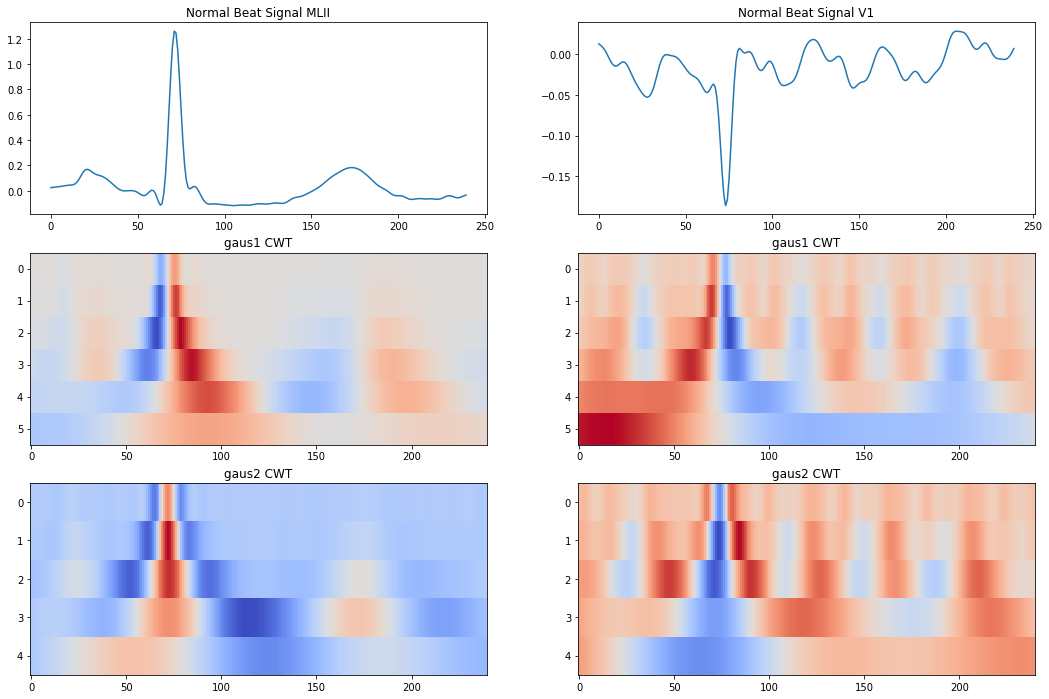

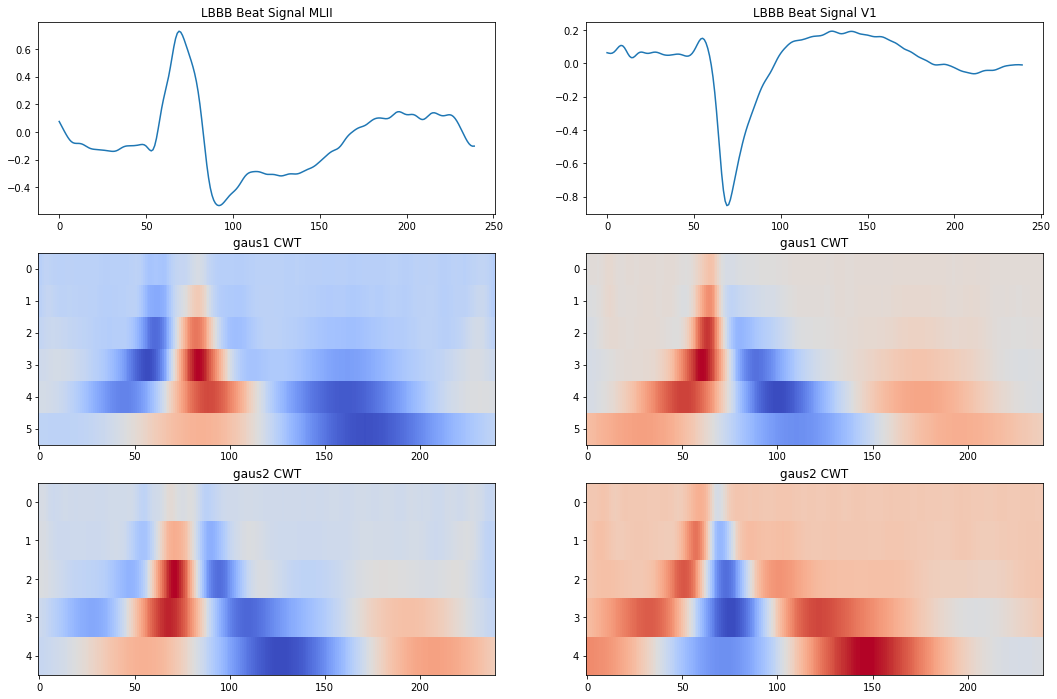

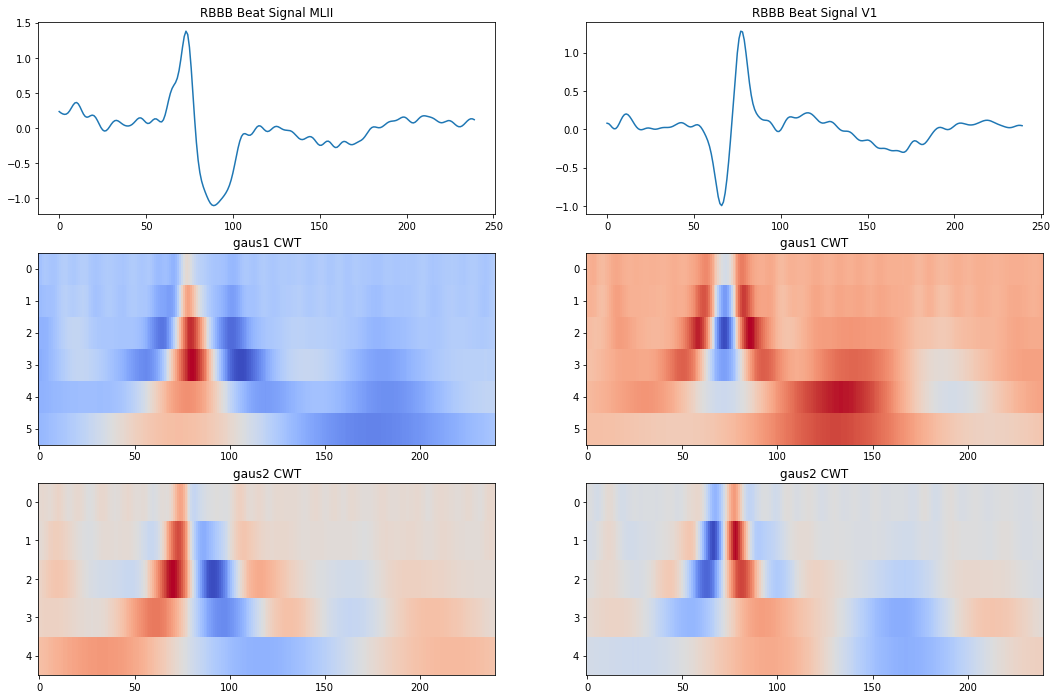

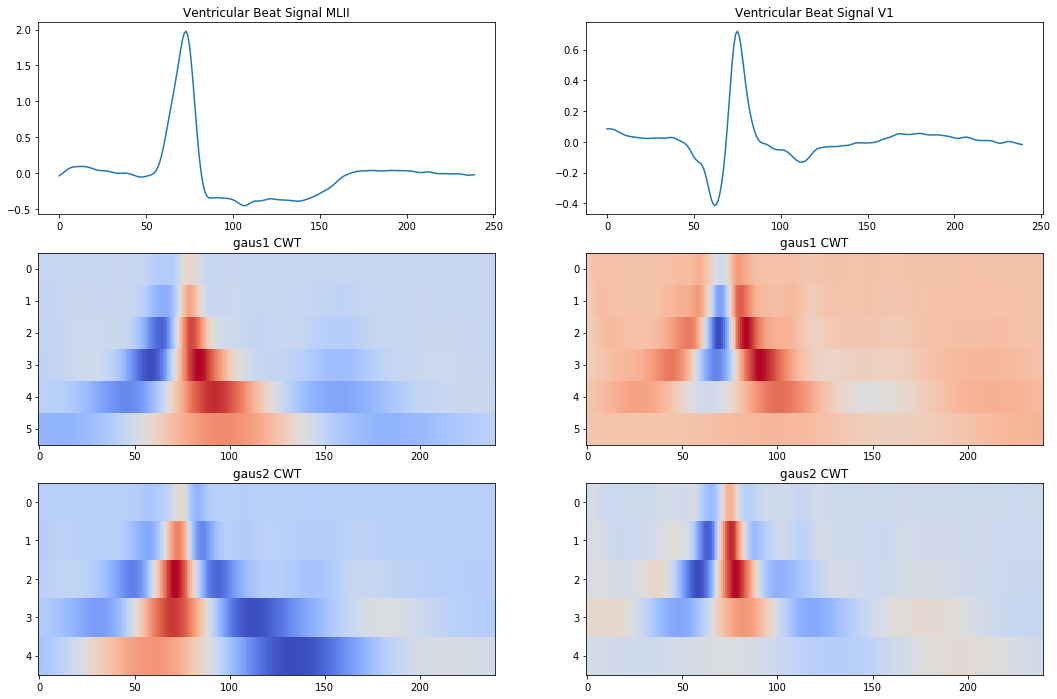

In [43]:
# Show the CWT applied to each sample beat
for beatnum in range(4):
    show_beat_cwt(beat=sample_beats[beatnum], beat_label=BEAT_TYPES[beatnum])

## Section 2 - Building Features from CWT

In [6]:
# For each beat, we want a set of features to feed into a classifier
# Each beat will have two wavelet families tested on its two channels.
FEATURE_NAMES = []

for ch in range(2):
    for wnum in range(2):
        for extraction_feature in ['maxcoef', 'maxind', 'mincoef', 'minind']:
            for scale in ecg_wavelet_scales[wnum]:
                FEATURE_NAMES.append('{}_{}_sc{}_{}'.format(
                    wavelet_types[wnum], SIG_NAMES[ch], scale, extraction_feature))
            

In [7]:
def calc_cwt_features(beat):
    """
    Calculate the CWT features for the 2 channel beat
    """
    features = []
    for ch in range(2):
        for wnum in range(2):
            # Calculate continuous wavelet transform
            coef, freqs = pywt.cwt(beat[:, ch], scales=ecg_wavelet_scales[wnum],
                                   wavelet=wavelet_types[wnum], sampling_period=dt)
                
            # The maximum and minimum values of the cwt array for each scale,
            # along with their sample indices
            max_coef, min_coef = np.max(coef, axis=1), np.min(coef, axis=1)
            max_ind, min_ind = np.argmax(coef, axis=1), np.argmin(coef, axis=1)
            
            # Append the list of features
            features += max_coef.tolist()
            features += min_coef.tolist()
            features += max_ind.tolist()
            features += min_ind.tolist()
    return features
    

## Section 3 - Calculate wavelet features and classify

In [8]:
# Get all the beats and labels together
all_beats = n_beats + l_beats + r_beats + v_beats
labels = [0]*len(n_beats) + [1]*len(l_beats) + [2]*len(r_beats) + [3]*len(v_beats)

In [11]:
# Calculate features for all records using multiple cpus
pool = Pool(processes=cpu_count() - 1)
features = pool.map(calc_cwt_features, all_beats)

# Combine features into a data frame
features = pd.DataFrame(features , columns=FEATURE_NAMES)

In [10]:
# Question: How many rows and columns should the feature matrix have?
features.head()

,gaus1_MLII_sc2_maxcoef,gaus1_MLII_sc4_maxcoef,gaus1_MLII_sc8_maxcoef,gaus1_MLII_sc16_maxcoef,gaus1_MLII_sc32_maxcoef,gaus1_MLII_sc64_maxcoef,gaus1_MLII_sc2_maxind,gaus1_MLII_sc4_maxind,gaus1_MLII_sc8_maxind,gaus1_MLII_sc16_maxind,...,gaus2_V1_sc4_mincoef,gaus2_V1_sc8_mincoef,gaus2_V1_sc16_mincoef,gaus2_V1_sc32_mincoef,gaus2_V1_sc64_mincoef,gaus2_V1_sc4_minind,gaus2_V1_sc8_minind,gaus2_V1_sc16_minind,gaus2_V1_sc32_minind,gaus2_V1_sc64_minind
0,0.954423,1.741266,2.015980,1.961642,1.631330,0.873753,-1.054788,-1.928027,-2.096179,-1.594493,...,81,84,90,118,232,74,73,71,71,63
1,0.882411,1.590420,1.939767,1.877950,1.526858,0.735337,-0.989376,-1.818404,-2.016893,-1.588660,...,67,64,153,112,234,74,75,176,72,68
2,0.953827,1.763518,2.178709,2.135875,1.776431,0.934225,-1.047455,-1.998969,-2.286047,-1.832184,...,68,64,97,6,0,75,75,76,72,66
3,0.973371,1.813232,2.209668,2.161741,1.745696,0.820773,-1.065185,-2.055131,-2.410791,-1.974515,...,82,85,90,224,127,75,74,71,188,61
4,1.032071,1.935617,2.338795,2.236313,1.777819,0.914096,-1.087113,-2.086168,-2.417248,-1.924723,...,69,65,58,11,4,75,76,78,76,71


### Visualize some results so that we can see if there is any inter-group difference

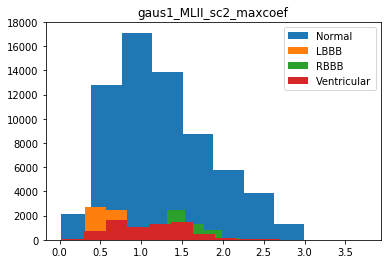

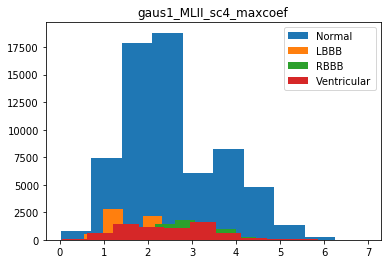

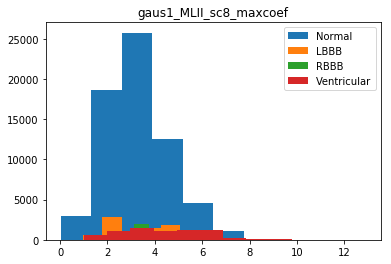

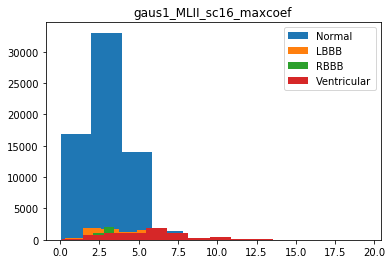

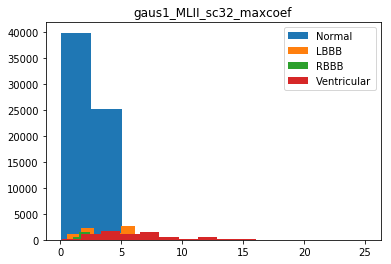

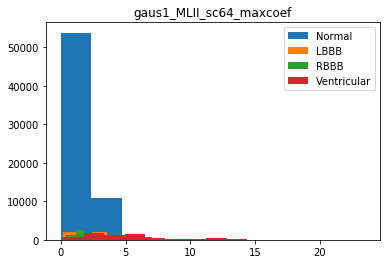

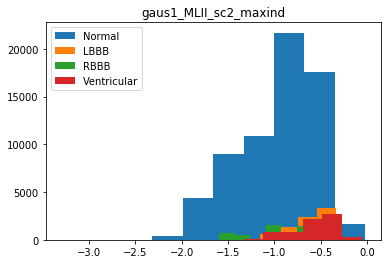

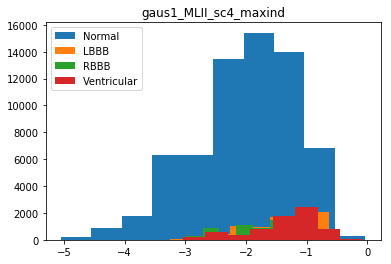

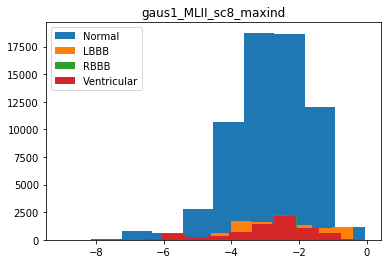

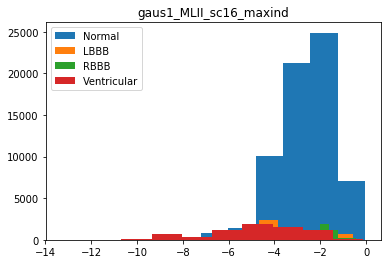

In [12]:
# Show some features
for f in FEATURE_NAMES[:10]:
    plt.figure()
    for groupnum in range(4):
        plt.hist(features.loc[np.equal(labels, groupnum), f])
    plt.title(f)
    plt.legend(BEAT_TYPES)
    plt.show()

In [17]:
# Normalize the features
features_norm = MinMaxScaler().fit_transform(features)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features_norm, labels,
                                                    train_size=0.75, test_size=0.25,
                                                    random_state=0)
print('Number of training records: %d' % len(x_train))
print('Number of testing records: %d' % len(x_test))

Number of training records: 64803
Number of testing records: 21602


### Train and Evaluate Classifiers

In [14]:
# LR
t0 = time.time()
clf_lr = LogisticRegression()
clf_lr.fit(x_train, y_train)
y_predict_lr = clf_lr.predict(x_test)
t_lr = time.time() - t0
print('LR training complete in {:.2f} seconds'.format(t_lr))

# KNN
t0 = time.time()
clf_knn = neighbors.KNeighborsClassifier()
clf_knn.fit(x_train, y_train)
y_predict_knn = clf_knn.predict(x_test)
t_knn = time.time() - t0
print('KNN training complete in {:.2f} seconds'.format(t_knn))

# SVM (WARNING - MAY TAKE SEVERAL MINUTES)
t0 = time.time()
clf_svm = svm.SVC()
clf_svm.fit(x_train, y_train)
y_predict_svm = clf_svm.predict(x_test)
t_svm = time.time() - t0
print('SVM training complete in {:.2f} seconds'.format(t_svm))

# GB (WARNING - MAY TAKE SEVERAL MINUTES)
t0 = time.time()
clf_gb = GradientBoostingClassifier()
clf_gb.fit(x_train, y_train)
y_predict_gb = clf_gb.predict(x_test)
t_gb = time.time() - t0
print('GB training complete in {:.2f} seconds'.format(t_gb))

LR training complete in 11.24 seconds
KNN training complete in 45.86 seconds
SVM training complete in 219.57 seconds
GB training complete in 308.14 seconds


In [25]:
# Show final performance
print('Logistic Regression')
print(classification_report(y_test, y_predict_lr, target_names=BEAT_TYPES))

print('K Nearest Neigbors')
print(classification_report(y_test, y_predict_knn, target_names=BEAT_TYPES))

print('Support Vector Machines')
print(classification_report(y_test, y_predict_svm, target_names=BEAT_TYPES))

print('Gradient Boosting')
print(classification_report(y_test, y_predict_gb, target_names=BEAT_TYPES))

Logistic Regression
             precision    recall  f1-score   support

     Normal       0.99      0.99      0.99     16464
       LBBB       0.92      0.94      0.93      2005
       RBBB       0.99      0.98      0.99      1430
Ventricular       0.94      0.88      0.91      1703

avg / total       0.98      0.98      0.98     21602

K Nearest Neigbors
             precision    recall  f1-score   support

     Normal       0.99      1.00      0.99     16464
       LBBB       0.98      0.98      0.98      2005
       RBBB       0.98      0.99      0.99      1430
Ventricular       0.97      0.94      0.95      1703

avg / total       0.99      0.99      0.99     21602

Support Vector Machines
             precision    recall  f1-score   support

     Normal       0.98      0.99      0.99     16464
       LBBB       0.88      0.94      0.91      2005
       RBBB       0.99      0.97      0.98      1430
Ventricular       0.95      0.82      0.88      1703

avg / total       0.97      

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
cm = confusion_matrix(y_test, y_predict_gb)

In [28]:
cm

array([[16443,     2,     0,    19],
       [    6,  1987,     0,    12],
       [    0,     0,  1428,     2],
       [   68,     3,     2,  1630]])

In [33]:
roc_auc_score(y_test, y_predict_gb)

ValueError: multiclass format is not supported